# **주요 내용**
모델 가중치 확인

In [1]:
import tensorflow as tf
tf.__version__

'2.2.0-rc2'

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4604425659946341031, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9337570312051187521
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10399866857844995850
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11150726272
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18286358532262698594
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [3]:
import platform
platform.platform()

'Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic'

In [4]:
!nvidia-smi

Tue Apr  7 12:28:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    70W / 149W |    130MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**파일 압축 해제 (드라이브에는 *.zip 파일 형식으로 저장되어 있음)**

In [6]:
import os

pcm_path = "./pcm_dataset"
wav_path = "./wav_dataset"

# mkdir
if not os.path.exists(pcm_path):
    os.mkdir(pcm_path)

if not os.path.exists(wav_path):
    os.mkdir(wav_path)

# unzip with quite mode (-q options)
!unzip -q "/content/drive/My Drive/ETRI/9_voice_download_4_Korean_English_by_Korean_part2.zip" -d "./pcm_dataset"

print(os.listdir(pcm_path)[:5])
print(len(os.listdir(pcm_path)))

['GSM06044JBY0', 'GSM05953CJH0', 'GSF06934SYN0', 'GSF03732JJH0', 'GSM07355MIW0']
50


***.pcm to *.wav**

In [7]:
import wave

for i, folder_path in enumerate(sorted(os.listdir(pcm_path))): # sorted!!!
    file_list = os.listdir(os.path.join(pcm_path, folder_path)) # label's path
    file_list_pcm = [files for files in file_list if files.endswith(".pcm")] # *.pcm files

    for j, file_path in enumerate(sorted(file_list_pcm)): # sorted!!!
        with open(os.path.join(pcm_path, folder_path, file_path), "rb") as pcm_file:
            pcm_data = pcm_file.read()
        # save as {label}_{features}.wav format
        with wave.open(os.path.join(wav_path, "{}_{}.wav".format(i, j)), 'wb') as wav_file:
            wav_file.setparams((1, 2, 16000, 0, 'NONE', 'NONE')) # 16kHz, mono channel
            wav_file.writeframes(pcm_data)

# print samples
print(os.listdir(wav_path)[:5])
print(len(os.listdir(wav_path)))

['28_87.wav', '9_64.wav', '24_79.wav', '28_59.wav', '2_34.wav']
5000


In [0]:
import numpy as np

num_labels = 50
num_features = 100
sr = 16000
duration = 1

train_rate = 0.8
num_train_data = int(num_features * train_rate) # 80

select_train_data = [True] * num_train_data + [False] * (num_features - num_train_data)
select_test_data = [False] * num_train_data + [True] * (num_features - num_train_data)

# naming
save_train_data_name = 'train_data'
save_train_labels_name = 'train_labels'

save_test_data_name = 'test_data'
save_test_labels_name = 'test_labels'

**train data, test data로 구분하여 numpy 저장 (*.npz)**

In [9]:
# save features as *.npz format

from scipy.io import wavfile

data = np.zeros((num_labels * num_features, duration * sr))
labels = np.zeros((num_labels * num_features))

for i in range(num_labels):
    for j in range(num_features):
        file_name = "{}_{}.wav".format(i, j)
        sample_rate, samples = wavfile.read(os.path.join(wav_path, file_name))
        
        # extract 1 sec (i.e. 'duration * sr' length) of each files
        start = int(len(samples)//2 - duration * sample_rate / 2)
        end = int(len(samples)//2 + duration * sample_rate / 2)
        
        data[i * num_features + j] = samples[start:end]
        labels[i * num_features + j] = i

train_data = data[select_train_data * num_labels]
train_labels = labels[select_train_data * num_labels]

test_data = data[select_test_data * num_labels]
test_labels = labels[select_test_data * num_labels]

# save *.npy        
np.save("./" + save_train_data_name, train_data)
np.save("./" + save_train_labels_name, train_labels)

np.save("./" + save_test_data_name, test_data)
np.save("./" + save_test_labels_name, test_labels)

print("train_data.shape: {}, train_labels.shape: {}".format(train_data.shape, train_labels.shape))
print("test_data.shape: {}, test_labels.shape: {}".format(test_data.shape, test_labels.shape))

train_data.shape: (4000, 16000), train_labels.shape: (4000,)
test_data.shape: (1000, 16000), test_labels.shape: (1000,)


**train data, validation data 분할 및 전처리 (normalization)**

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

random_state = 1234
len_data = train_data.shape[1] # 16000
test_size = 0.2

X_train, X_val, Y_train, Y_val = train_test_split(train_data, train_labels,
                                                  test_size = test_size,
                                                  random_state = random_state) # fixed

x_train = X_train.reshape(len(X_train), len_data, 1)
x_val = X_val.reshape(len(X_val), len_data, 1) 

y_train = to_categorical(Y_train)
y_val = to_categorical(Y_val)

# standarization
mean = x_train.mean()
x_train -= mean
std = x_train.std()
x_train /= std

x_val -= mean
x_val /= std 

print("test_size: {}, random_state: {}\n".format(test_size, random_state))
print('x_train.shape: {}, y_train.shape: {}'.format(x_train.shape, y_train.shape))
print('x_val.shape: {}, y_val.shape: {}'.format(x_val.shape, y_val.shape))

test_size: 0.2, random_state: 1234

x_train.shape: (3200, 16000, 1), y_train.shape: (3200, 50)
x_val.shape: (800, 16000, 1), y_val.shape: (800, 50)


**Build Model (GlobalAveragePooling1D())**

In [14]:
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

model = Sequential()
model.add(layers.Conv1D(16, 5, activation = 'relu', input_shape = (sr * duration, 1)))
model.add(layers.MaxPooling1D(5))

model.add(layers.Conv1D(32, 7, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(5))

model.add(layers.Conv1D(64, 7, activation = 'relu'))
model.add(layers.MaxPooling1D(5))

model.add(layers.Conv1D(128, 7, activation = 'relu'))
model.add(layers.Conv1D(128, 8, activation = 'relu'))
model.add(layers.BatchNormalization())
# model.add(layers.GlobalMaxPooling1D())
model.add(layers.GlobalAveragePooling1D())

model.add(layers.Dense(num_labels, activation = 'softmax'))

model.compile(optimizer = 'rmsprop',
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

model.summary()
# plot_model(model, show_shapes = True, to_file = 'model.png')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 15996, 16)         96        
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 3199, 16)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 3193, 32)          3616      
_________________________________________________________________
batch_normalization_4 (Batch (None, 3193, 32)          128       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 638, 32)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 632, 64)           14400     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 126, 64)          

**모델 훈련 및 저장**

In [15]:
from datetime import datetime

batch_size = 80
epochs = 100

history = model.fit(x_train, y_train,
                    validation_data = (x_val, y_val),
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 1) # 1 → 훈련과정 보기, 0 → 훈련과정 생략

save_model_path = "/content/drive/My Drive/models" # save to my drive
if not os.path.exists(save_model_path):
    os.mkdir(save_model_path)

model.save(os.path.join(save_model_path, "{}.h5".format(datetime.today().strftime("%Y_%m_%d_%H_%M_%S"))))

Epoch 1/100
40/40 [==============================] - 3s 82ms/step - loss: 2.8715 - accuracy: 0.2747 - val_loss: 3.8016 - val_accuracy: 0.0350
Epoch 2/100
40/40 [==============================] - 3s 74ms/step - loss: 1.7596 - accuracy: 0.6081 - val_loss: 3.9535 - val_accuracy: 0.0250
Epoch 3/100
40/40 [==============================] - 3s 75ms/step - loss: 1.1936 - accuracy: 0.7500 - val_loss: 4.1762 - val_accuracy: 0.0413
Epoch 4/100
40/40 [==============================] - 3s 74ms/step - loss: 0.8798 - accuracy: 0.8222 - val_loss: 4.3654 - val_accuracy: 0.0288
Epoch 5/100
40/40 [==============================] - 3s 75ms/step - loss: 0.6575 - accuracy: 0.8637 - val_loss: 4.1773 - val_accuracy: 0.0475
Epoch 6/100
40/40 [==============================] - 3s 74ms/step - loss: 0.5069 - accuracy: 0.8966 - val_loss: 4.4872 - val_accuracy: 0.0425
Epoch 7/100
40/40 [==============================] - 3s 74ms/step - loss: 0.4268 - accuracy: 0.9128 - val_loss: 4.7502 - val_accuracy: 0.0338
Epoch 

**히스토리 출력**

In [16]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


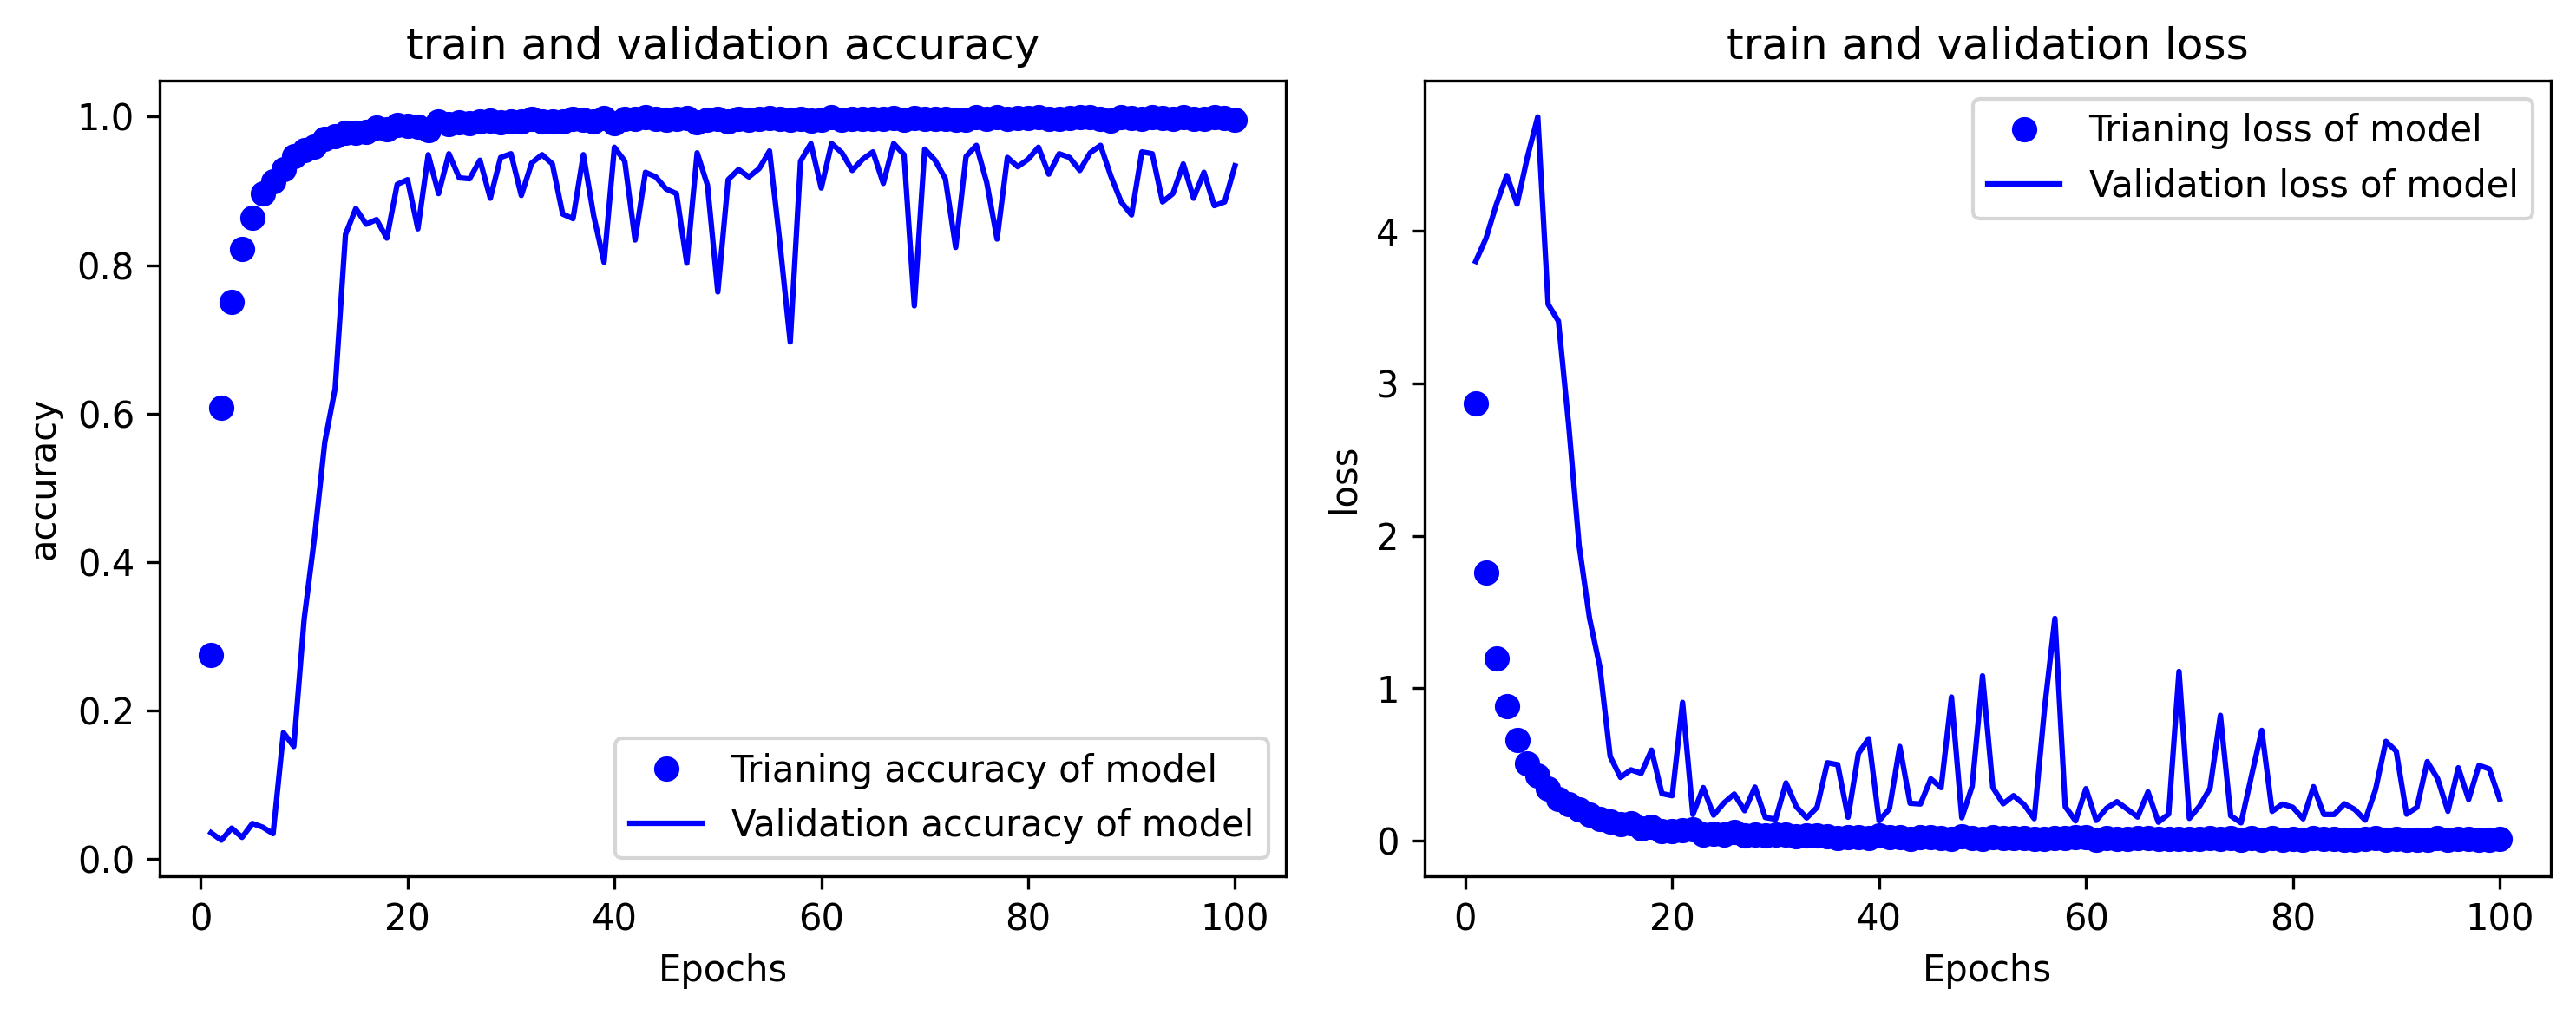

In [17]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize = (10, 4), facecolor = 'white', dpi = 300)

# accuracy
plt.subplot(1, 2, 1)

plt.plot(range(1, epochs + 1), acc, 'bo', label = 'Trianing accuracy of model')
plt.plot(range(1, epochs + 1), val_acc, 'b', label = 'Validation accuracy of model')
plt.title('train and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

# loss
plt.subplot(1, 2, 2)

plt.plot(range(1, epochs + 1), loss, 'bo', label = 'Trianing loss of model')
plt.plot(range(1, epochs + 1), val_loss, 'b', label = 'Validation loss of model')
plt.title('train and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.tight_layout()
plt.show()

**test data를 통해 모델 최종 평가 (field test)**

In [18]:
# reshaping
del test_data, test_labels

test_data = np.load(save_test_data_name + ".npy")
test_labels = np.load(save_test_labels_name + ".npy")

test_data = test_data.reshape(len(test_data), len_data, 1)
test_labels = to_categorical(test_labels)

# standarization
test_data -= mean
test_data /= std 

print('test_data.shape: {}, test_labels.shape: {}'.format(test_data.shape, test_labels.shape))

test_data.shape: (1000, 16000, 1), test_labels.shape: (1000, 50)


In [19]:
results = model.evaluate(test_data, test_labels, batch_size = batch_size)

print('test loss, test acc:', results)

13/13 [==============================] - 1s 48ms/step - loss: 0.1490 - accuracy: 0.9600
test loss, test acc: [0.1489524096250534, 0.9599999785423279]


**Layer name 확인**

In [20]:
layer_names = np.array([])
for layer in model.layers:
    layer_names = np.append(layer_names, layer.name)

print(layer_names)

['conv1d_10' 'max_pooling1d_6' 'conv1d_11' 'batch_normalization_4'
 'max_pooling1d_7' 'conv1d_12' 'max_pooling1d_8' 'conv1d_13' 'conv1d_14'
 'batch_normalization_5' 'global_average_pooling1d_2' 'dense_2']


**모델 weight & bias 확인**

conv1d()는 weight (size: (kernel size, # of input filters, # of output filters))와 bias (size: (# of output filters))의 가중치를 가짐.

Dense()는 weight (size: (input shape))와 bias (size: (output shape))의 가중치를 가짐.

batchnormalization()은 4개의 가중치 (size: (input shape))를 가짐. 

max_pooling1d, global_average_normalization은 가중치를 가지지 않음.

https://datascienceschool.net/view-notebook/51e147088d474fe1bf32e394394eaea7/

https://keras.io/ko/layers/convolutional/

In [58]:
for l in model.layers:
    print("{}".format(l.name))

    for w in l.get_weights():
        print(w.shape, end = " ")
    
    print('\n' if l.get_weights() else 'None\n')

conv1d_10
(5, 1, 16) (16,) 

max_pooling1d_6
None

conv1d_11
(7, 16, 32) (32,) 

batch_normalization_4
(32,) (32,) (32,) (32,) 

max_pooling1d_7
None

conv1d_12
(7, 32, 64) (64,) 

max_pooling1d_8
None

conv1d_13
(7, 64, 128) (128,) 

conv1d_14
(8, 128, 128) (128,) 

batch_normalization_5
(128,) (128,) (128,) (128,) 

global_average_pooling1d_2
None

dense_2
(128, 50) (50,) 



In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 15996, 16)         96        
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 3199, 16)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 3193, 32)          3616      
_________________________________________________________________
batch_normalization_4 (Batch (None, 3193, 32)          128       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 638, 32)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 632, 64)           14400     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 126, 64)          

https://www.researchgate.net/publication/327594319_A_Complete_End-to-End_Speaker_Verification_System_Using_Deep_Neural_Networks_From_Raw_Signals_to_Verification_Result